Variational Autoencoder test

Python version: x <br>
PyTorch version: y <br>
Numpy version: z <br>

In [272]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
print(torch.__version__)
print(np.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")

print(DEVICE)

image_size = (16, 16)
image_vector_dim = image_size[0] * image_size[1]

object_size = (8, 8)

input_dimension = image_size[0] * image_size[1]
hidden_dimension_encoder = 60
latent_dimension = 2
hidden_dimension_decoder = 60

output_dimension = image_size[0] * image_size[1]

dataset_size = 5000
batch_size = 10
epochs = 50
learning_rate = 0.001

2.5.0+cu118
2.1.0
cuda


In [273]:
from typing import Tuple
import matplotlib.pyplot as plt

class RandomObjectDataset(Dataset):
    def __init__(self, dataset_size, image_size, object_size):
        self.dataset_size = dataset_size
        self.image_size = image_size
        self.object_size = object_size

    def __len__(self) -> int:
        return self.dataset_size

    def __getitem__(self, idx: int):
        z = torch.zeros(self.image_size)
        o = torch.ones(self.object_size)

        object_x_min = 0
        object_x_max = self.image_size[0] - self.object_size[0]

        object_y_min = 0
        object_y_max = self.image_size[0] - self.object_size[0]

        object_x = np.random.randint(object_x_min, object_x_max)
        object_y = np.random.randint(object_y_min, object_y_max)

        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = o        
        return z

class DiagonalObjectDataset(Dataset):
    def __init__(self, batch_size, image_size, object_size):
        self.batch_size = batch_size
        self.image_size = image_size
        self.object_size = object_size
        
    def __len__(self) -> int:
        return self.batch_size

    def __getitem__(self, idx: int):  
        z = torch.zeros(self.image_size)
        o = torch.ones(self.object_size)
        
        object_x_max = self.image_size[0] - self.object_size[0]
        object_y_max = self.image_size[0] - self.object_size[0]

        step_x = object_x_max / (self.batch_size - 1)
        step_y = object_y_max / (self.batch_size - 1)

        object_x = step_x * idx
        object_y = step_y * idx
        #object_x = (object_x_max )*(float(idx+1) / float(self.batch_size))
        #object_y = (object_y_max )*(float(idx+1) / float(self.batch_size))

        object_x = int(object_x)
        object_y = int(object_y)
        
        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = o        
        return z
        
#dataset_test = RandomImageDataset(image_size = image_size)
#plt.imshow(dataset_test.__getitem__(123), cmap='gray')
#plt.axis('off')
#plt.title('Test image')
#plt.show()

dataset_training = RandomObjectDataset(dataset_size=dataset_size, image_size=image_size, object_size=object_size)
dataset_testing = RandomObjectDataset(dataset_size=batch_size, image_size=image_size, object_size=object_size)

dataset_diagonal = DiagonalObjectDataset(batch_size=2, image_size=image_size, object_size=object_size)

dataloader_training = DataLoader(dataset_training, batch_size=batch_size)
dataloader_testing = DataLoader(dataset_testing, batch_size=batch_size)
dataloader_diagonal = DataLoader(dataset_diagonal, batch_size=2)

In [274]:
# Encoder
class StandardEncoder(torch.nn.Module):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(StandardEncoder, self).__init__()
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.latent_dimension = latent_dimension

        self.fc0 = torch.nn.Linear(input_dimension, hidden_dimension)
        self.mean = torch.nn.Linear(hidden_dimension, latent_dimension)
        self.lat = torch.nn.Linear(hidden_dimension, latent_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        #mean = self.mean(t)
        lat = self.lat(t)

        return lat
        #return mean, var



class VariationalEncoder(StandardEncoder):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(VariationalEncoder, self).__init__(input_dimension=input_dimension, hidden_dimension=hidden_dimension, latent_dimension=latent_dimension)
        #self.input_dimension = input_dimension
        #self.hidden_dimension = hidden_dimension
        #self.latent_dimension = latent_dimension

        #self.fc0 = torch.nn.Linear(input_dimension, hidden_dimension)
        #self.mean = torch.nn.Linear(hidden_dimension, latent_dimension)
        self.var = torch.nn.Linear(hidden_dimension, latent_dimension)

        #self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        mean = self.lat(t)
        var = self.var(t)

        return mean, var


In [275]:
# Decoder

class Decoder(torch.nn.Module):
    def __init__(self, latent_dimension, hidden_dimension, output_dimension):
        super(Decoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

        self.fc0 = torch.nn.Linear(latent_dimension, hidden_dimension)
       
        #self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        self.output = torch.nn.Linear(hidden_dimension, output_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        
        t = torch.sigmoid(self.output(t))

        return t
    

In [276]:
# Model

class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

        
    def forward(self, data):
        mean, var = self.encoder(data)
        e = torch.randn_like(var).to(DEVICE)
        latent = mean + torch.exp(0.5* var) * e
        
        data_ = self.decoder(latent)

        return data_, mean, var, latent

    def get_decoder(self):
        return self.decoder
        
class StandardAutoencoder(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(StandardAutoencoder, self).__init__()
        self.encoder = StandardEncoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

    def forward(self, data):
        lat = self.encoder(data)
        data_ = self.decoder(lat)

        return data_, lat
        
    def get_decoder(self):
        return self.decoder
        
vae = VariationalAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)
sae = StandardAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)
vae.to(DEVICE)
sae.to(DEVICE)

# loss

from torch.optim import Adam

def vae_loss(data, data_, mean, var):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    KLD = -0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())
    return loss + KLD

def sae_loss(data, data_):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    return loss

optimizer_vae = Adam(vae.parameters(), lr = learning_rate)
optimizer_sae = Adam(sae.parameters(), lr = learning_rate)


vae.train()
sae.train()

for e in range(epochs):
    epoch_loss_vae = 0
    epoch_loss_sae = 0
    for data in dataloader_training:
        data = data.view(batch_size, image_vector_dim)
        data = data.to(DEVICE)

        optimizer_vae.zero_grad()
        optimizer_sae.zero_grad()

        data_vae, mean, var, lat_vae = vae(data)
        data_sae, lat_sae            = sae(data)
        
        loss_vae = vae_loss(data, data_vae, mean, var)
        loss_sae = sae_loss(data, data_sae)
        
        epoch_loss_vae += loss_vae.item()
        epoch_loss_sae += loss_sae.item()
        
        loss_vae.backward()
        loss_sae.backward()
        optimizer_vae.step()
        optimizer_sae.step()
    print("epoch",e," loss_vae:", epoch_loss_vae, " loss_sae:", epoch_loss_sae)

epoch 0  loss_vae: 367300.1448364258  loss_sae: 311040.51834106445
epoch 1  loss_vae: 167011.5393371582  loss_sae: 154343.14213562012
epoch 2  loss_vae: 120470.23779296875  loss_sae: 111186.31764221191
epoch 3  loss_vae: 97869.4048614502  loss_sae: 78495.83934020996
epoch 4  loss_vae: 84501.01672363281  loss_sae: 56091.031105041504
epoch 5  loss_vae: 74746.47008514404  loss_sae: 40682.08729362488
epoch 6  loss_vae: 67880.955909729  loss_sae: 31415.300451278687
epoch 7  loss_vae: 62662.23095703125  loss_sae: 24284.364592552185
epoch 8  loss_vae: 58097.34980010986  loss_sae: 17849.4431848526
epoch 9  loss_vae: 54511.78246307373  loss_sae: 12713.496512889862
epoch 10  loss_vae: 52143.12021636963  loss_sae: 12089.190852165222
epoch 11  loss_vae: 49384.932121276855  loss_sae: 7152.057721614838
epoch 12  loss_vae: 47634.75547790527  loss_sae: 8278.50250172615
epoch 13  loss_vae: 45448.005950927734  loss_sae: 8052.678541183472
epoch 14  loss_vae: 43961.53652191162  loss_sae: 7081.573523640633

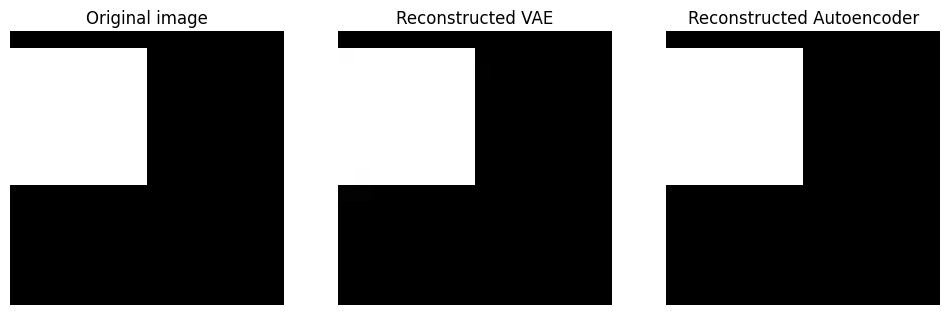

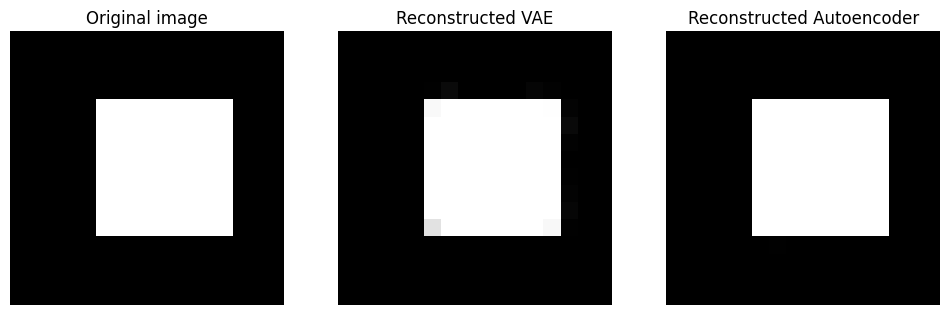

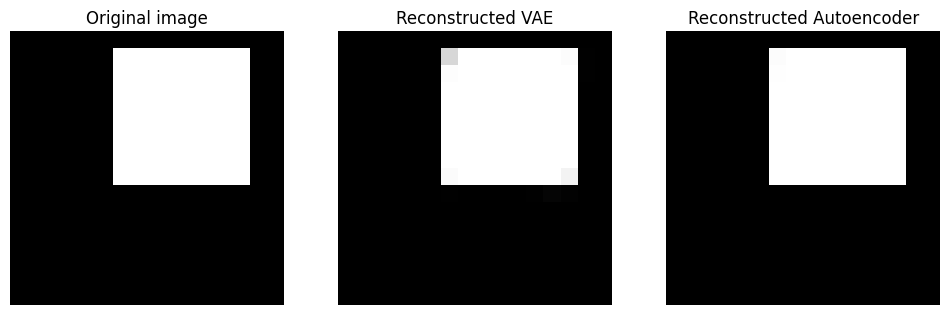

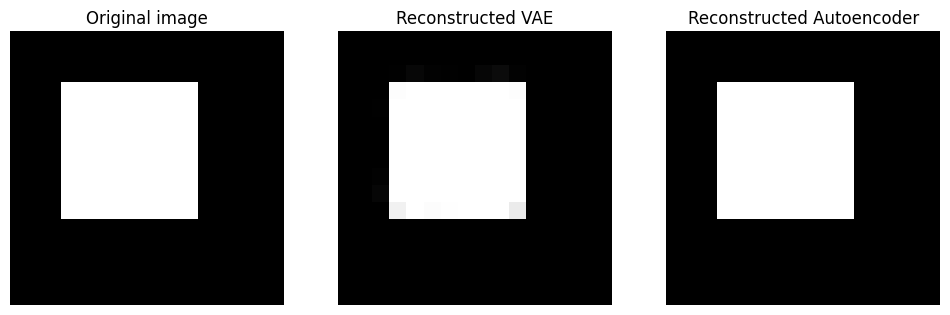

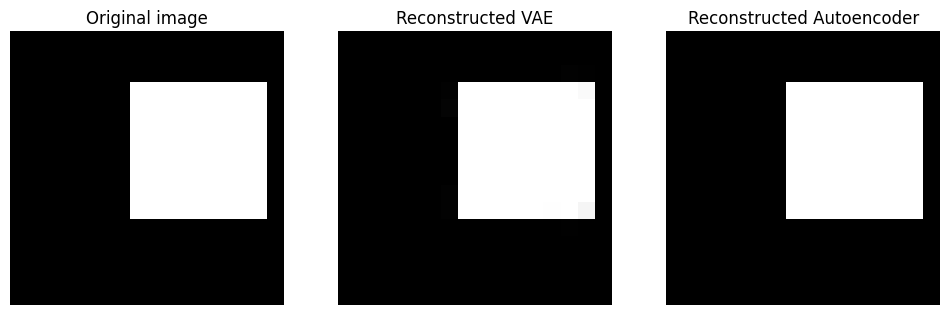

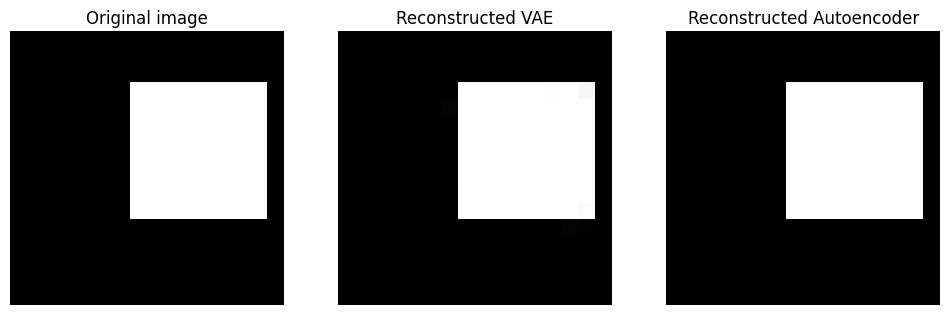

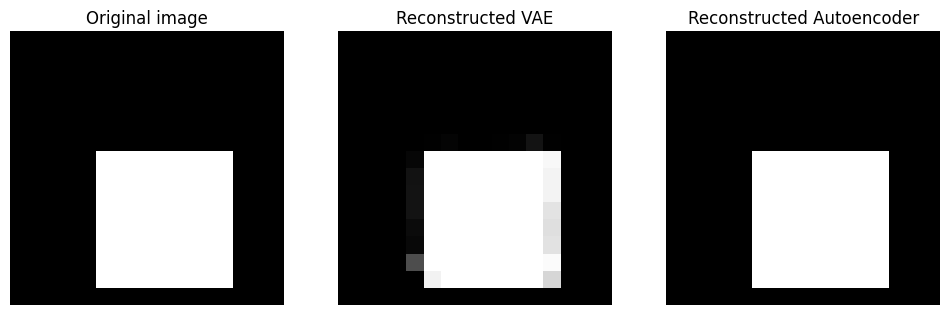

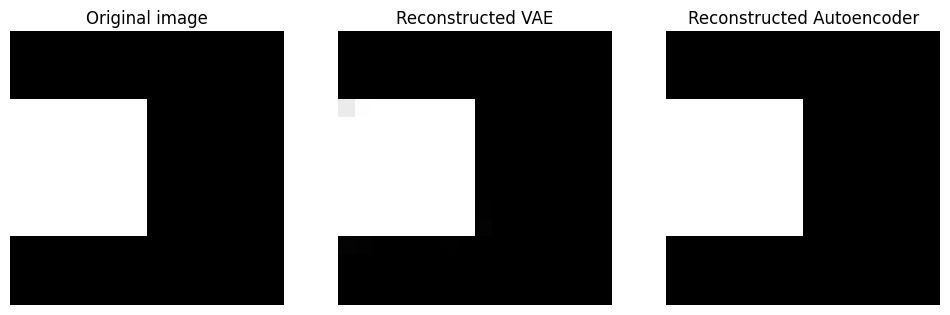

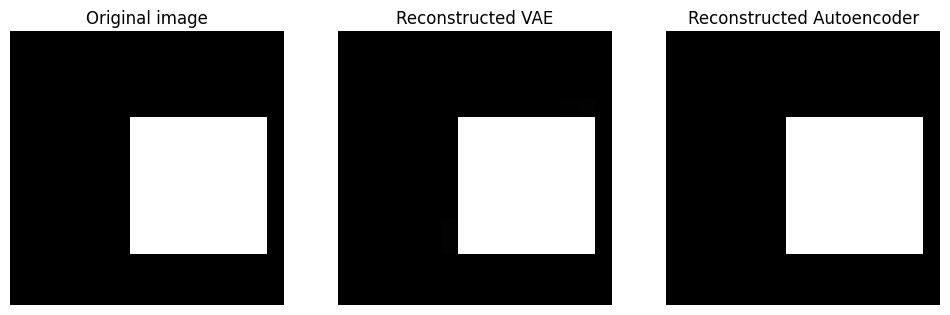

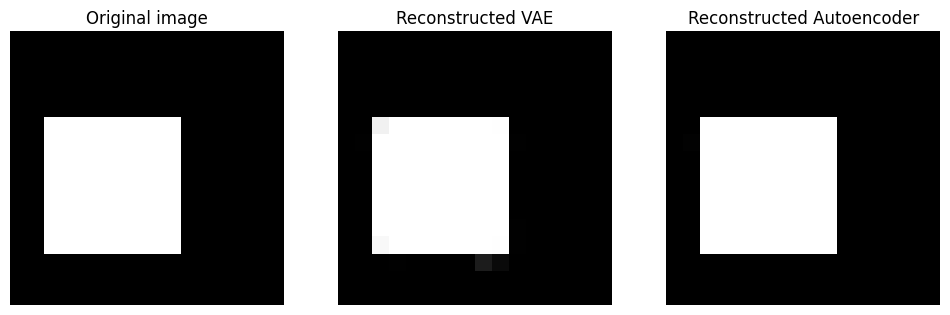

torch.Size([10, 16, 16])


In [277]:
# Visualize

vae.eval()
sae.eval()

dataloader = dataloader_testing
bs = dataloader.batch_size

for data in dataloader:
    data = data.view(bs, image_vector_dim)
    
    data=data.to(DEVICE)

    data_vae, mean, variance, lat_vae = vae(data)
    data_sae, lat_sae                 = sae(data)
    
    
    data = data.view(bs, image_size[0], image_size[1])
    data_vae = data_vae.view(bs, image_size[0], image_size[1])
    data_sae = data_sae.view(bs, image_size[0], image_size[1])

    
    for i in range(bs):
        im0 = data[i]
        im0_np = im0.cpu().detach().numpy()
        im1 = data_vae[i]
        im1_np = im1.cpu().detach().numpy()
        im2 = data_sae[i]
        im2_np = im2.cpu().detach().numpy()
        
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.imshow(im0_np, cmap='gray')
        plt.axis('off')
        plt.title('Original image')
        plt.subplot(1,3,2)
        plt.imshow(im1_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed VAE')
        plt.subplot(1,3,3)
        plt.imshow(im2_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed Autoencoder')
        
        plt.show()
    print(data_.shape)
    #break



[[-0.69228333  2.6894684 ]
 [ 0.5938495  -2.2218547 ]]


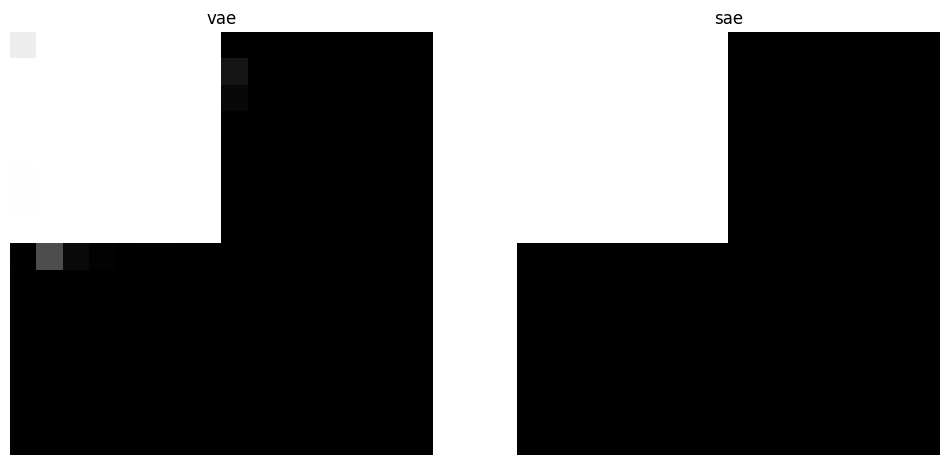

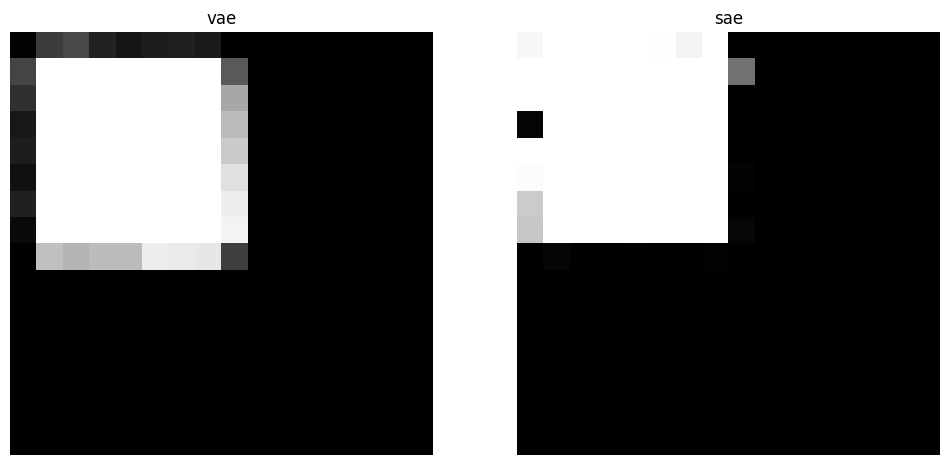

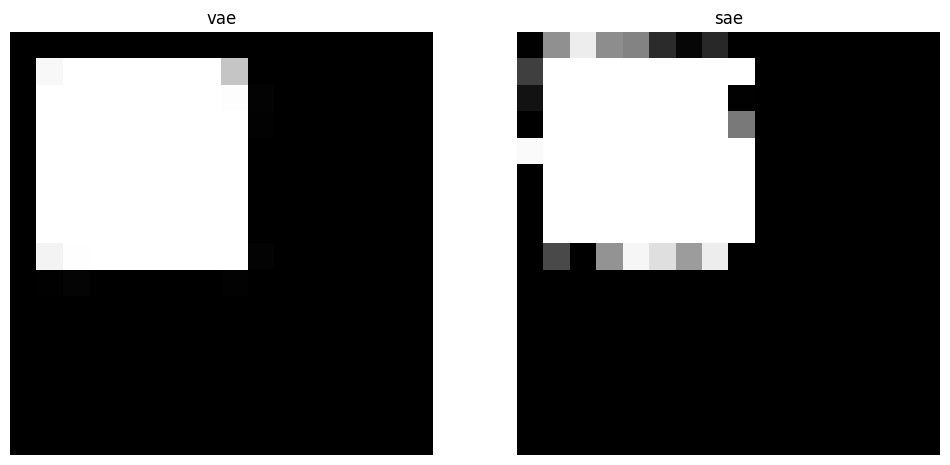

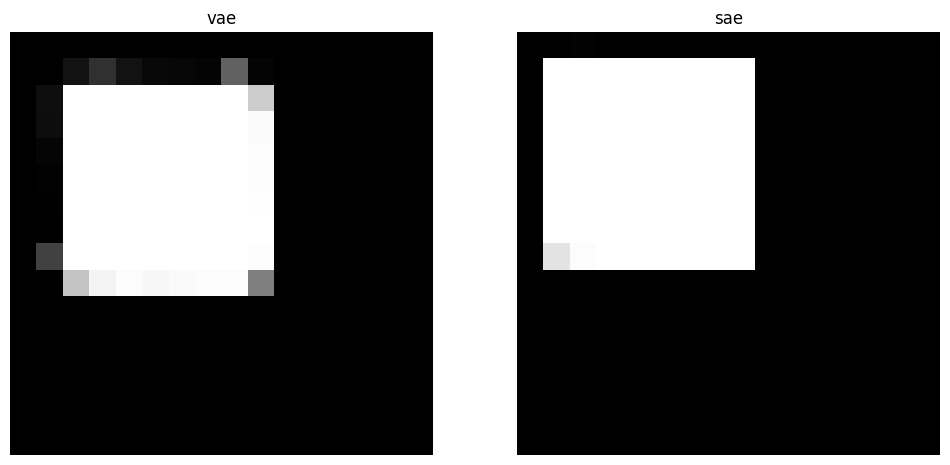

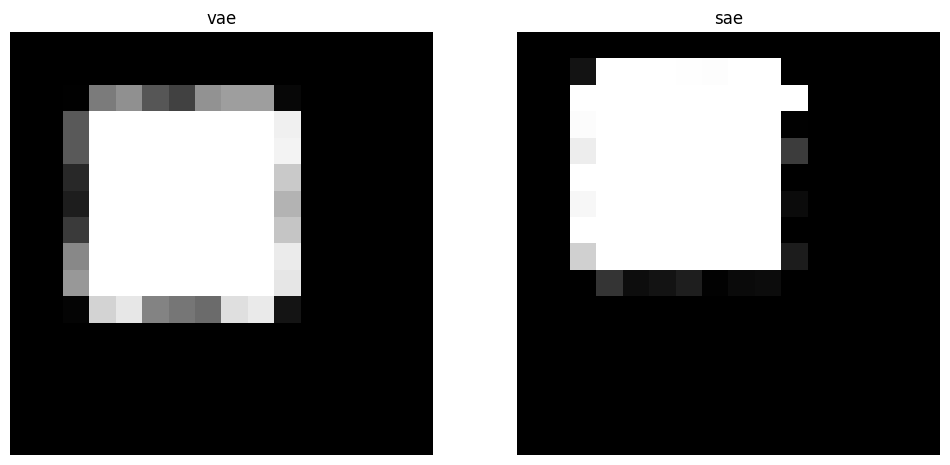

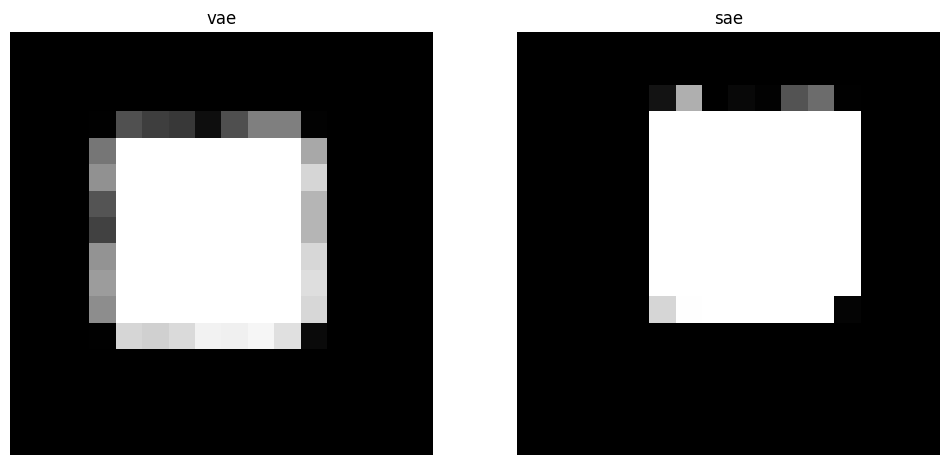

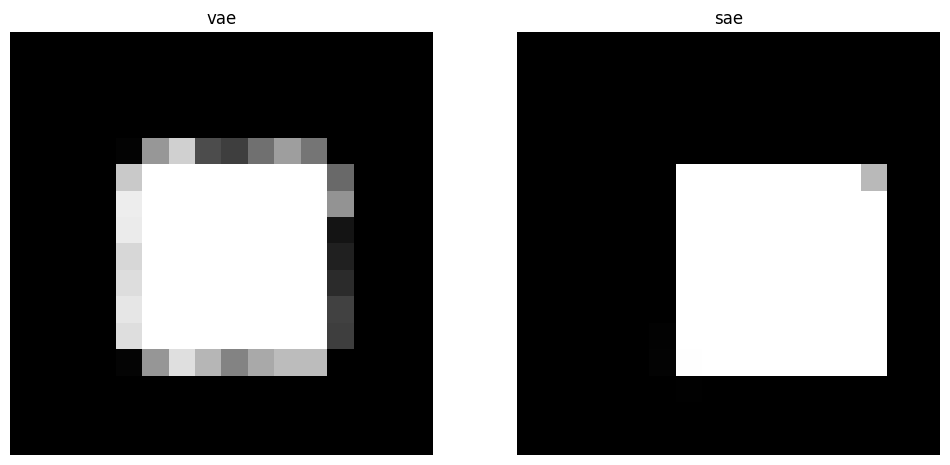

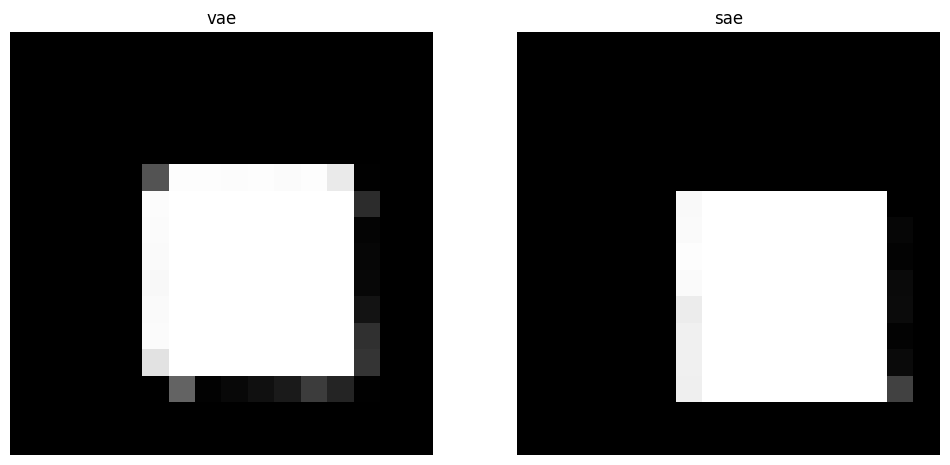

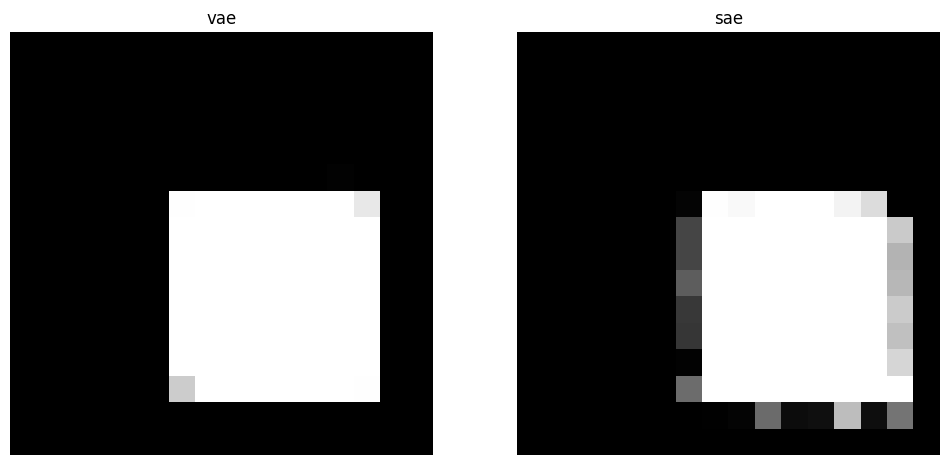

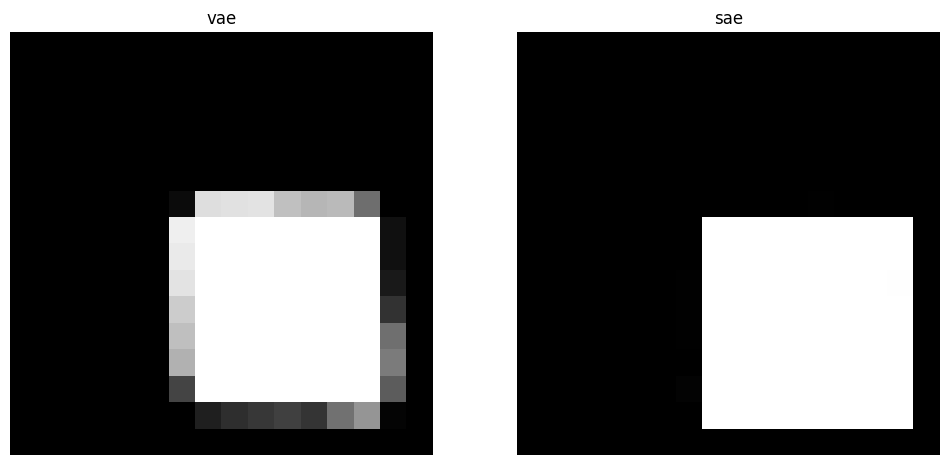

In [281]:

batch = next(iter(dataloader_diagonal))

batch = batch.view(dataloader_diagonal.batch_size, image_vector_dim)
batch = batch.to(DEVICE);

batch_vae, mean, variance, lat_vae = vae(batch)
batch_sae, lat_sae                 = sae(batch)

print(lat_vae.cpu().detach().numpy())
#print(lat_sae.cpu().detach().numpy()) 

latent_steps = 10

def linear_tensor_interpolation(p, n_points):
    start, end = p[0], p[1]
    pi = torch.stack([(1 - t) * start + t * end for t in torch.linspace(0, 1, n_points)])

    return pi
    
lat_vae_interpolated = linear_tensor_interpolation(lat_vae, latent_steps)
lat_sae_interpolated = linear_tensor_interpolation(lat_sae, latent_steps)
#lat_vae_interpolated = lat_vae
#lat_sae_interpolated = lat_sae

#print(lat_vae_interpolated)
#print(lat_sae_interpolated)

vae_decoder = vae.get_decoder()
sae_decoder = sae.get_decoder()

im_vae = vae_decoder(lat_vae_interpolated)
im_sae = sae_decoder(lat_sae_interpolated)

im_vae = im_vae.view(latent_steps, image_size[0], image_size[1])
im_sae = im_sae.view(latent_steps, image_size[0], image_size[1])

for x in range(latent_steps):
    imv = im_vae[x]
    ims = im_sae[x]

    imv = imv.cpu().detach().numpy()
    ims = ims.cpu().detach().numpy()
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(imv, cmap='gray')
    plt.axis('off')
    plt.title('vae')
    plt.subplot(1,2,2)
    plt.imshow(ims, cmap='gray')
    plt.axis('off')
    plt.title('sae')
    